In [3]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import lightgbm as lgb
from scipy.stats import poisson
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
from sklearn import preprocessing, metrics

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for MacOS TF bug

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/Users/joeranbosma/opt/anaconda3/envs/mlip/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv


/Users/joeranbosma/opt/anaconda3/envs/mlip/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/joeranbosma/opt/anaconda3/envs/mlip/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library b

In [5]:
# import functions from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
from lightgbm_kernel import (reduce_mem_usage, read_data, encode_categorical, simple_fe, \
                            weight_calc, make_wrmsse, agg_series, SPL, meanSPL, mymeanSPL)

In [6]:
calendar, sell_prices, sales_train_val, submission = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [5]:
NUM_ITEMS = sales_train_val.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1   # 28

In [6]:
calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 94.01 Mb (78.9% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [7]:
nrows = 365 * 2 * NUM_ITEMS
# nrows = 365 // 6 * NUM_ITEMS
nrows

22257700

In [8]:
sales_train_val = pd.melt(sales_train_val,
                          id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                          var_name = 'day', value_name = 'demand')
print('Melted sales train validation has {} rows and {} columns'.format(*sales_train_val.shape))

Melted sales train validation has 58327370 rows and 8 columns


In [9]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0


In [10]:
sales_train_val = sales_train_val.iloc[-nrows:,:]

In [11]:
# from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
# separate test dataframes
forecast_submission = pd.concat([submission.iloc[0:int(771120/2),:].iloc[-30490:,:],submission.iloc[int(771120/2):,:].iloc[-30490:,:]])
forecast_submission['id'] = forecast_submission['id'].str.replace('_.\...._','_')
forecast_submission.drop_duplicates(inplace=True)

# submission fileのidのvalidation部分と, ealuation部分の名前を取得
test1_rows = [row for row in forecast_submission['id'] if 'validation' in row]
test2_rows = [row for row in forecast_submission['id'] if 'evaluation' in row]

# submission fileのvalidation部分をtest1, ealuation部分をtest2として取得
test1 = forecast_submission[forecast_submission['id'].isin(test1_rows)]
test2 = forecast_submission[forecast_submission['id'].isin(test2_rows)]

# test1, test2の列名の"F_X"の箇所をd_XXX"の形式に変更
test1.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
test2.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

# test2のidの'_evaluation'を置換
#test1['id'] = test1['id'].str.replace('_validation','')
test2['id'] = test2['id'].str.replace('_evaluation','_validation')

# sales_train_valからidの詳細部分(itemやdepartmentなどのid)を重複なく一意に取得。
product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

# idをキーにして, idの詳細部分をtest1, test2に結合する.
test1 = test1.merge(product, how = 'left', on = 'id')
test2 = test2.merge(product, how = 'left', on = 'id')

# test1, test2をともにmelt処理する.（売上数量:demandは0）
test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

# validation部分と, evaluation部分がわかるようにpartという列を作り、 test1,test2のラベルを付ける。
sales_train_val['part'] = 'train'
test1['part'] = 'test1'
test2['part'] = 'test2'

# sales_train_valとtest1, test2の縦結合.
data = pd.concat([sales_train_val, test1, test2], axis = 0)

# memoryの開放
del test1, test2, sales_train_val, forecast_submission

# delete test2 for now(6/1以前は, validation部分のみ提出のため.)
data = data[data['part'] != 'test2']

gc.collect()

14

In [12]:
#calendarの結合
# drop some calendar features(不要な変数の削除:weekdayやwdayなどはdatetime変数から後ほど作成できる。)
calendar.drop(['weekday', 'wday', 'month', 'year'],
              inplace = True, axis = 1)

# notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

# memoryの開放
del  calendar
gc.collect()

#sell priceの結合
# get the sell price data (this feature should be very important)
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# memoryの開放
del  sell_prices
gc.collect()

Our final dataset to train has 22257700 rows and 18 columns


36

In [13]:
data = reduce_mem_usage(simple_fe(data, DAYS_PRED=DAYS_PRED))

Mem. usage decreased to 2356.15 Mb (46.4% reduction)


In [14]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [15]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend"
]

## Train model (and free up memory)

In [35]:
weight_mat = np.c_[np.identity(NUM_ITEMS).astype(np.int8),  # item :level 12
                   np.ones([NUM_ITEMS, 1]).astype(np.int8),  # level 1
                   pd.get_dummies(product.state_id.astype(str), drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str), drop_first=False).astype('int8').values,
                   pd.get_dummies(product.cat_id.astype(str), drop_first=False).astype('int8').values,
                   pd.get_dummies(product.dept_id.astype(str), drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype(
                       'int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype(
                       'int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype(
                       'int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype(
                       'int8').values,
                   pd.get_dummies(product.item_id.astype(str), drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str), drop_first=False).astype(
                       'int8').values
].T

weight_mat_csr = csr_matrix(weight_mat)
del weight_mat
gc.collect()



weight1, weight2 = weight_calc(data, weight_mat_csr=weight_mat_csr)

/Users/joeranbosma/stack/Projects/M5Forecast/lightgbm_kernel.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_tmp['amount'] = df_tmp['demand'] * df_tmp['sell_price']


In [ ]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'custom',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'colsample_bytree': 0.75}

In [18]:
train_set = lgb.Dataset(x_train[features], y_train)
val_set = lgb.Dataset(x_val[features], y_val)

del x_train, y_train
gc.collect()

40

In [23]:
wrmsse = make_wrmsse(NUM_ITEMS, weight_mat_csr, weight1, weight2)
evals_result = {}  # to record eval results for plotting

model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50,
                  valid_sets = [train_set, val_set], verbose_eval = 50, feval = wrmsse,
                  evals_result=evals_result,)

Training until validation scores don't improve for 50 rounds
[50]	training's wrmsse: 0.852455	valid_1's wrmsse: 0.664422
[100]	training's wrmsse: 0.723018	valid_1's wrmsse: 0.585648
[150]	training's wrmsse: 0.684598	valid_1's wrmsse: 0.574563
[200]	training's wrmsse: 0.67426	valid_1's wrmsse: 0.569545
[250]	training's wrmsse: 0.665965	valid_1's wrmsse: 0.569038
[300]	training's wrmsse: 0.657227	valid_1's wrmsse: 0.565167
[350]	training's wrmsse: 0.644446	valid_1's wrmsse: 0.560853
[400]	training's wrmsse: 0.639157	valid_1's wrmsse: 0.559493
[450]	training's wrmsse: 0.633388	valid_1's wrmsse: 0.559052
Early stopping, best iteration is:
[420]	training's wrmsse: 0.636024	valid_1's wrmsse: 0.557734


In [28]:
model.save_model("models/lgb/model-baseline-kernel.txt")

In [29]:
ax = lgb.plot_metric(evals_result, metric='wrmsseb')
plt.show()

TypeError: booster must be dict or LGBMModel.

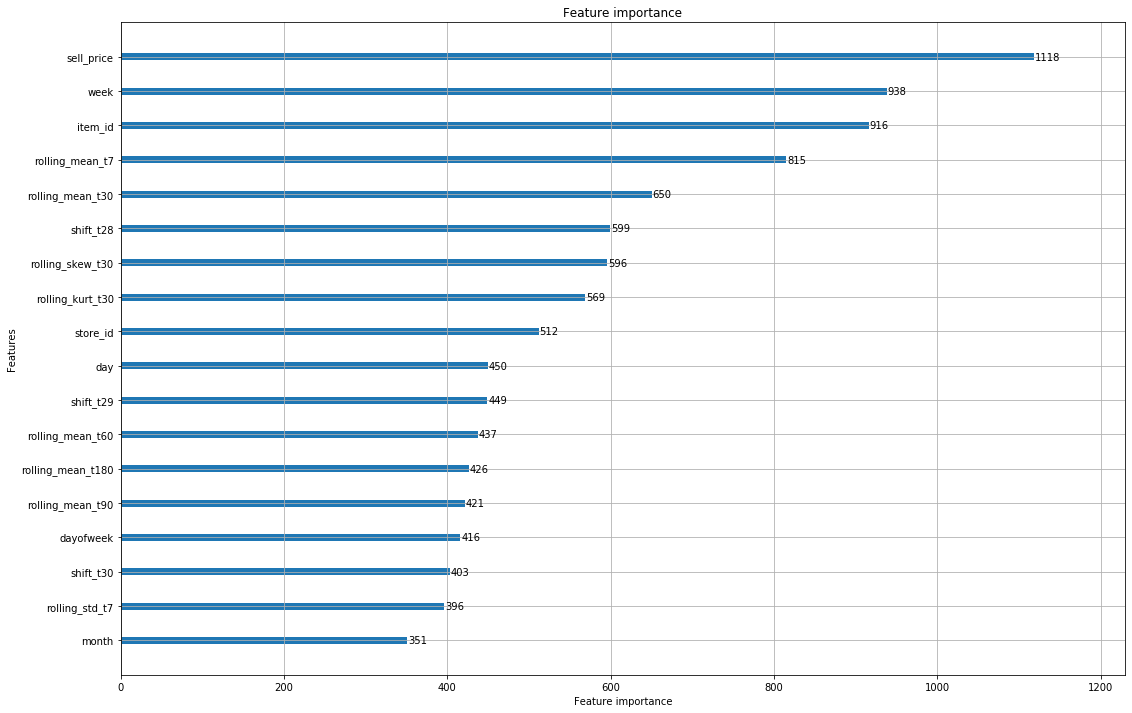

In [115]:
f, ax = plt.subplots(1, 1, figsize=(18, 12))
ax = lgb.plot_importance(model, max_num_features=18, ax=ax)
plt.show()

## Load trained model

In [16]:
model = lgb.Booster(model_file="models/lgb/model-baseline-kernel.txt")

## Error distribution

In [17]:
%%time
y_pred = model.predict(x_train[features])

CPU times: user 10min 56s, sys: 9.91 s, total: 11min 5s
Wall time: 55.6 s


In [18]:
# treat each prediction y as the estimated mean of a poisson distribution with mean y
# and use ppf to obtain the corresponding estimates of the percentiles
ids = x_train['id'].unique()
day_start = np.datetime64(x_train.date.min().date())
day_end = np.datetime64(x_train.date.max().date())
num_days = (day_end - day_start + 1).astype(int)

y_pred_df = pd.DataFrame.from_dict({
    'id': np.repeat(ids, num_days),
    'date': np.tile(np.arange(day_start, day_end+1),30490),
    'pred': y_pred,
    'demand': x_train['demand'],
})
y_pred_df['item_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
y_pred_df['dept_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
y_pred_df['cat_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
y_pred_df['store_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
y_pred_df['state_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:4]))

In [19]:
y_pred_df.head()

,id,date,pred,demand,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,2014-04-26,0.693689,0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,HOBBIES_1_001_CA_1_validation,2014-04-27,0.875063,0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
2,HOBBIES_1_001_CA_1_validation,2014-04-28,1.000967,0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
3,HOBBIES_1_001_CA_1_validation,2014-04-29,0.820877,1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
4,HOBBIES_1_001_CA_1_validation,2014-04-30,1.000967,0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA


In [20]:
y_pred_df['error'] = y_pred_df['demand'] - y_pred_df['pred']

In [21]:
print("df size: {:.2f} GB".format(y_pred_df.memory_usage().sum() / 1024**3))

df size: 1.63 GB


### Store level (3)

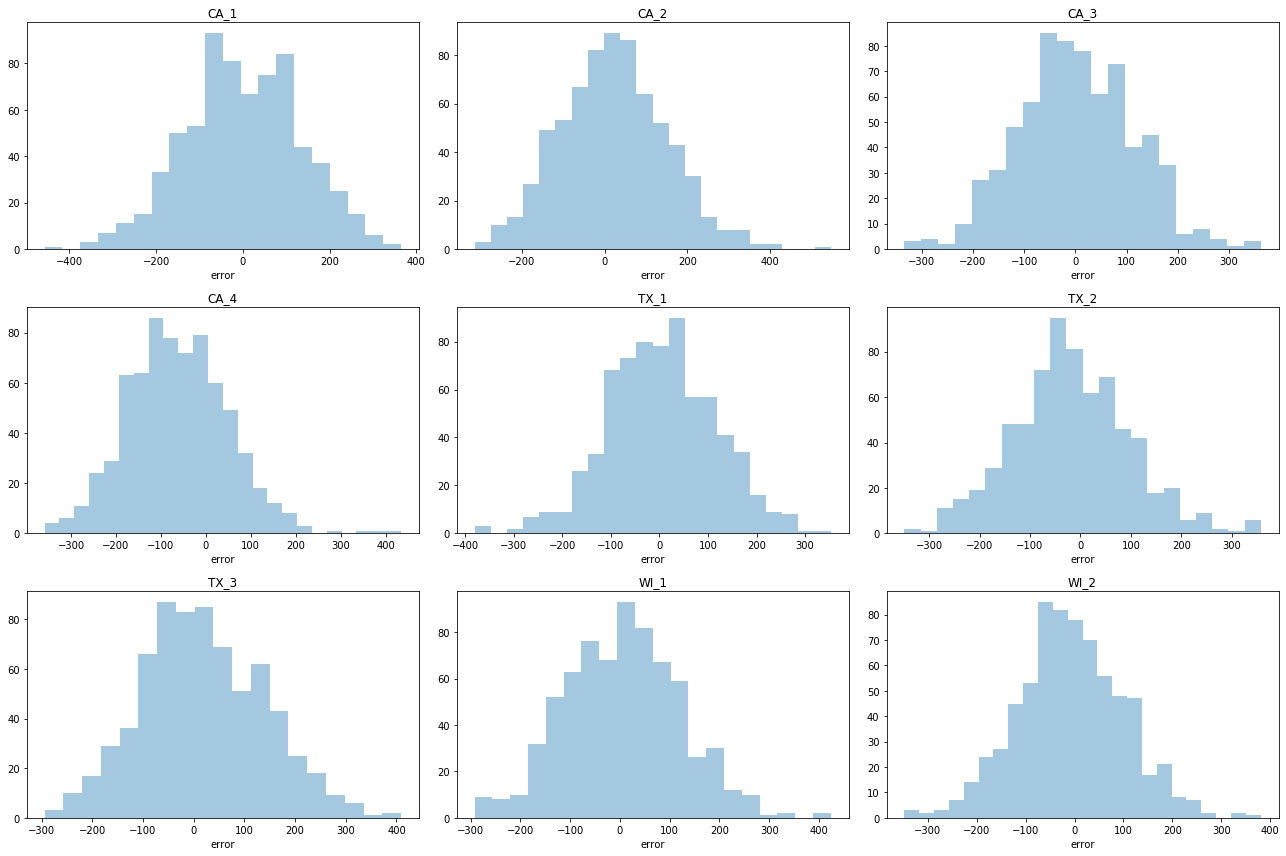

In [22]:
f, axes = plt.subplots(3, 3, figsize=(18 , 12))
errs = y_pred_df.groupby(['store_id', 'date'])['error'].sum()
for store_id, ax in zip(y_pred_df.store_id.unique(), np.ravel(axes)):
    sns.distplot(errs.loc[store_id, :], kde=False, ax=ax)
    ax.set_title(store_id)

f.tight_layout()
plt.show()

### Product level irrespective of store (level 10)

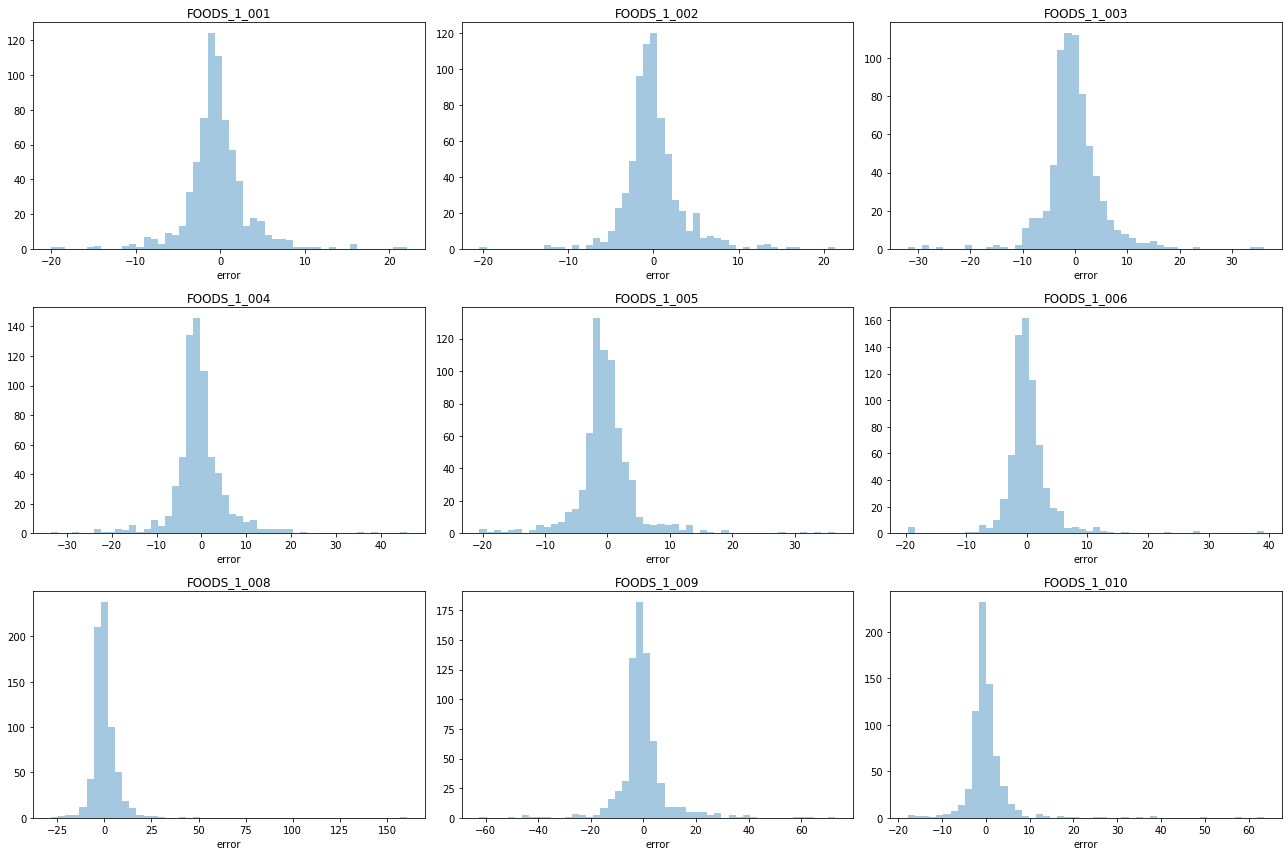

In [23]:
f, axes = plt.subplots(3, 3, figsize=(18 , 12))
errs = y_pred_df.groupby(['item_id', 'date'])['error'].sum()
for idx, ax in zip(errs.index.levels[0], np.ravel(axes)):
    sns.distplot(errs.loc[idx, :], kde=False, ax=ax)
    ax.set_title(idx)

f.tight_layout()
plt.show()

### Preduct level (12)

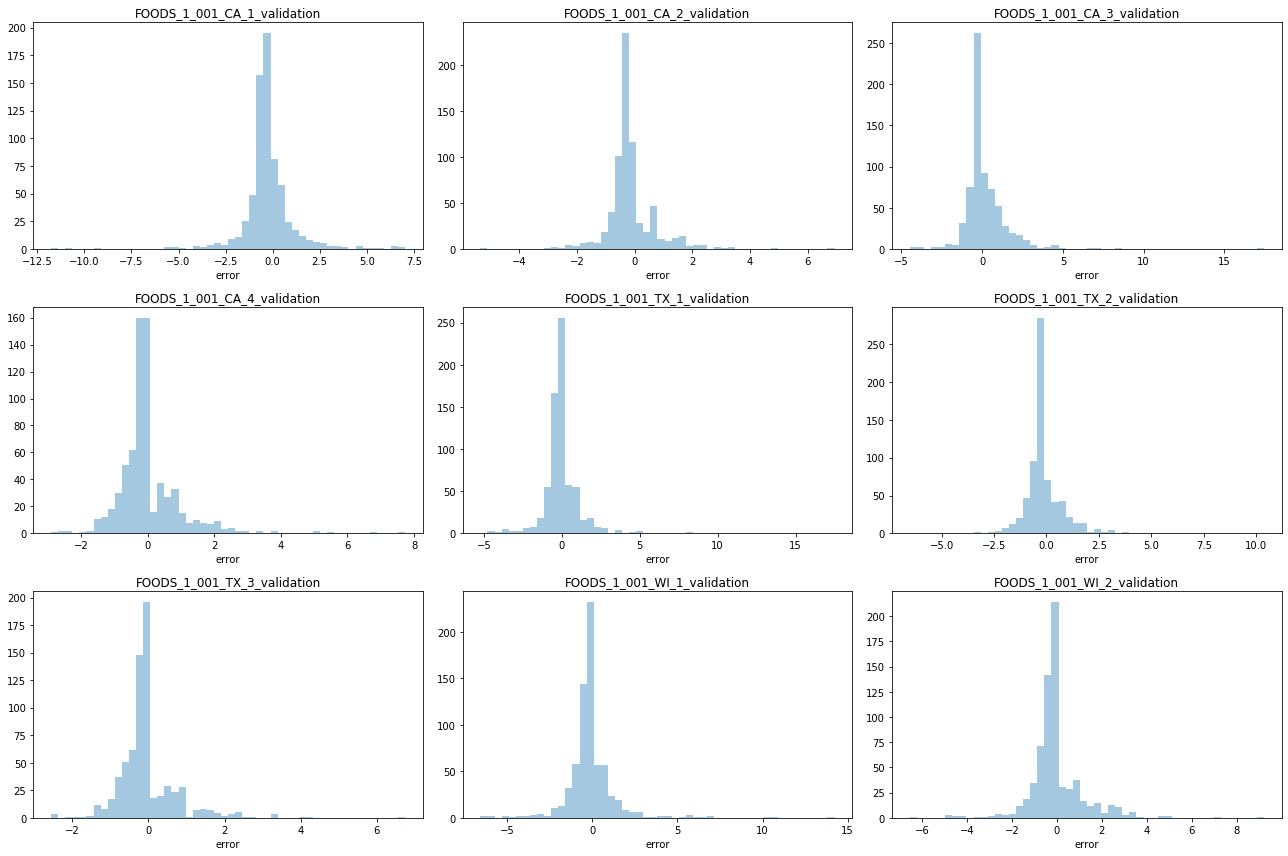

In [24]:
f, axes = plt.subplots(3, 3, figsize=(18 , 12))
errs = y_pred_df.groupby(['id', 'date'])['error'].sum()
for idx, ax in zip(errs.index.levels[0], np.ravel(axes)):
    sns.distplot(errs.loc[idx, :], kde=False, ax=ax)
    ax.set_title(idx)

f.tight_layout()
plt.show()

## Apply confidence intervals to predictions
Use the distribution of errors as global, 'true' distribution, so the distribution is static across days, but different for each level & each product etc. 

In [25]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
q_cols = ['0_{:03d}'.format(int(1000*q)) for q in quantiles]

In [28]:
## Dont have test set yet, so apply to validation set
test = x_val

In [27]:
# predictions for the mean of the uncertainty distribution
y_pred = model.predict(test[features])

In [29]:
# treat each prediction y as the estimated mean of a poisson distribution with mean y
# and use ppf to obtain the corresponding estimates of the percentiles
ids = test['id'].unique()
day_start = np.datetime64(test.date.min().date())
day_end = np.datetime64(test.date.max().date())
num_days = (day_end - day_start + 1).astype(int)

y_pred_q = pd.DataFrame.from_dict({
    'id': np.repeat(ids, num_days),
    'date': np.tile(np.arange(day_start, day_end+1), 30490),
    'pred': y_pred,
})
y_pred_q['item_id'] = y_pred_q['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
y_pred_q['dept_id'] = y_pred_q['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
y_pred_q['cat_id'] = y_pred_q['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
y_pred_q['store_id'] = y_pred_q['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
y_pred_q['state_id'] = y_pred_q['id'].map(lambda x: '_'.join(x.split('_')[3:4]))

In [30]:
y_pred_q.head()

,id,date,pred,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,2016-03-28,0.810988,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,HOBBIES_1_001_CA_1_validation,2016-03-29,0.263113,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
2,HOBBIES_1_001_CA_1_validation,2016-03-30,0.350568,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
3,HOBBIES_1_001_CA_1_validation,2016-03-31,1.624245,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
4,HOBBIES_1_001_CA_1_validation,2016-04-01,0.922919,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA


In [53]:
y_pred_q[y_pred_q.pred == y_pred_q.pred.max()]

,id,date,pred,item_id,dept_id,cat_id,store_id,state_id
801152,HOUSEHOLD_2_075_WI_3_validation,2016-04-13,186.690954,HOUSEHOLD_2_075,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI


In [327]:
x_train[x_train.id == 'HOUSEHOLD_2_075_WI_3_validation']

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,shift_t28,shift_t29,shift_t30,rolling_std_t7,rolling_std_t30,rolling_std_t60,rolling_std_t90,rolling_std_t180,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_skew_t30,rolling_kurt_t30,shift_price_t1,price_change_t1,rolling_price_max_t365,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,year,quarter,month,week,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend
28612,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,0,train,2014-04-26,11413,NaN,NaN,NaN,NaN,0,0,0,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,4,17,26,5,0,0,0,0,0,0,1
59102,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,0,train,2014-04-27,11413,NaN,NaN,NaN,NaN,0,0,0,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,NaN,NaN,2014,2,4,17,27,6,0,0,0,0,0,0,1
89592,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,1,train,2014-04-28,11413,NaN,NaN,NaN,NaN,0,0,0,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,NaN,NaN,2014,2,4,18,28,0,0,0,0,0,0,0,0
120082,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,0,train,2014-04-29,11413,NaN,NaN,NaN,NaN,0,0,0,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,NaN,NaN,2014,2,4,18,29,1,0,0,0,0,0,0,0
150572,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,1,train,2014-04-30,11413,NaN,NaN,NaN,NaN,0,0,0,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,NaN,NaN,2014,2,4,18,30,2,0,0,0,0,1,0,0
181062,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,3,train,2014-05-01,11413,NaN,NaN,NaN,NaN,1,1,0,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,NaN,NaN,2014,2,5,18,1,3,0,0,0,0,0,1,0
211552,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,0,train,2014-05-02,11413,NaN,NaN,NaN,NaN,1,0,1,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,0.0,NaN,2014,2,5,18,2,4,0,0,0,0,0,0,0
242042,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,1,train,2014-05-03,11414,NaN,NaN,NaN,NaN,1,1,1,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,0.0,NaN,2014,2,5,18,3,5,0,0,0,0,0,0,1
272532,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,0,train,2014-05-04,11414,NaN,NaN,NaN,NaN,1,0,0,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,0.0,NaN,2014,2,5,18,4,6,0,0,0,0,0,0,1
303022,HOUSEHOLD_2_075_WI_3_validation,2608,6,2,9,2,1,train,2014-05-05,11414,2.0,0.0,NaN,NaN,1,1,1,1.839844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839844,0.0,NaN,NaN,0.0,NaN,2014,2,5,19,5,0,0,0,0,0,0,0,0


### Apply to aggregated series

In [31]:
aggregation_levels = {
    1: [lambda x: 1],  # global: 1
    2: ['state_id'],  # per state: 3
    3: ['store_id'],  # per store: 10
    4: ['cat_id'],  # per category: 3
    5: ['dept_id'],  # per department: 7
    6: ['state_id', 'cat_id'],  # per state & cat: 9
    7: ['state_id', 'dept_id'],  # per state & dep: 21
    8: ['store_id', 'cat_id'],  # per store & cat: 30
    9: ['store_id', 'dept_id'],  # per store & dep: 70
    10: ['item_id'],  # per item, across stores/states: 3049
    11: ['item_id', 'state_id'],  # per item, across stores: 9,225
    12: ['id']  # lowest level, per product, per store
}

In [32]:
from tqdm import tqdm as tqdm

In [33]:
def get_idx(idx, level, postfix="_validation"):
    if level == 1:
        # total aggregates
        return "Total_X_{:.3f}".format(idx[-1]) + postfix
    elif (level >= 2 and level <= 5) or level == 10:
        # single-key aggregates
        return idx[0] + "_X_{:.3f}".format(idx[-1]) + postfix
    elif level >= 6 and level <= 9:
        # two-key aggregates
        return idx[0] + "_" + idx[1] + "_{:.3f}".format(idx[-1]) + postfix
    elif level == 11:
        # two-key aggregates reversed order
        return idx[1] + "_" + idx[0] + "_{:.3f}".format(idx[-1]) + postfix
    elif level == 12:
        return idx[0].replace('_validation', '') + "_{:.3f}".format(idx[-1]) + postfix
    assert False, "Index Error, level not recognised"

In [39]:
%%time
agg_preds = []
for level, groupby in aggregation_levels.items():
    print("Starting level {}, groupby {}".format(level, groupby))
    groupby_w_date = [*groupby, 'date']
    
    # calculate prediction errors
    errs = y_pred_df.groupby(groupby_w_date)['error'].sum()  # 1.8 s (all levels together)
    
    # calculate predictions as sum of individual, low level, predictions
    preds = y_pred_q.groupby(groupby_w_date)['pred'].sum()  # 1.5 s (all levels together)
    # create placeholder for quantiles
    preds = pd.concat([preds]*len(quantiles), axis=1)
    preds.columns = quantiles
    preds.columns.name = 'quantiles'
    
    # create indices for submission
    
    # convert errors to to quantiles: 0.005, 0.025, 0.165, 0.25 - 0.5 - 0.75, 0.835, 0.975, 0.995
    qs = errs.groupby(groupby).quantile(quantiles)  # 30-1.8 = 28.2 s (all levels together)
    
    # set quantiles as columns
    df = qs.unstack()
    # repeat each day x times, for each prediction day
    x = preds.index.levels[-1].size
    # add quantiles to point predictions (also to 0.500 quantile!)
    preds = pd.DataFrame(preds.values + df.loc[df.index.repeat(x)].values,
                         columns=quantiles,
                         index=preds.index)
    
    # swap quantiles and date as columns/index
    preds = preds.stack().unstack(level='date')
    
    # convert indices to submission convension
    preds.index = preds.index.map(lambda x: get_idx(x, level))
    preds.index.name = 'id'
    
    # save to list for later concat
    agg_preds.append(preds)

Starting level 1, groupby [<function <lambda> at 0x1d5bf4f950>]
Starting level 2, groupby ['state_id']
Starting level 3, groupby ['store_id']
Starting level 4, groupby ['cat_id']
Starting level 5, groupby ['dept_id']
Starting level 6, groupby ['state_id', 'cat_id']
Starting level 7, groupby ['state_id', 'dept_id']
Starting level 8, groupby ['store_id', 'cat_id']
Starting level 9, groupby ['store_id', 'dept_id']
Starting level 10, groupby ['item_id']
Starting level 11, groupby ['item_id', 'state_id']
Starting level 12, groupby ['id']
CPU times: user 2min 14s, sys: 17.3 s, total: 2min 32s
Wall time: 2min 36s


In [47]:
preds = pd.concat(agg_preds)

In [48]:
preds.head()

date,2016-03-28 00:00:00,2016-03-29 00:00:00,2016-03-30 00:00:00,2016-03-31 00:00:00,2016-04-01 00:00:00,2016-04-02 00:00:00,2016-04-03 00:00:00,2016-04-04 00:00:00,2016-04-05 00:00:00,2016-04-06 00:00:00,2016-04-07 00:00:00,2016-04-08 00:00:00,2016-04-09 00:00:00,2016-04-10 00:00:00,2016-04-11 00:00:00,2016-04-12 00:00:00,2016-04-13 00:00:00,2016-04-14 00:00:00,2016-04-15 00:00:00,2016-04-16 00:00:00,2016-04-17 00:00:00,2016-04-18 00:00:00,2016-04-19 00:00:00,2016-04-20 00:00:00,2016-04-21 00:00:00,2016-04-22 00:00:00,2016-04-23 00:00:00,2016-04-24 00:00:00
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Total_X_0.005_validation,42266.107454,41546.213972,42261.541540,41554.420334,42292.288715,41701.211944,42248.109805,41690.397028,42323.486666,41865.058645,42393.335995,41762.777073,42318.924449,41753.119699,42336.957611,41654.221095,42438.457603,41604.832372,42307.863136,41806.952556,42180.818436,41783.498858,42326.504558,41850.109667,42282.162641,41767.557293,42209.750007,41644.866078
Total_X_0.025_validation,42471.610056,41751.716574,42467.044141,41759.922935,42497.791317,41906.714546,42453.612406,41895.899630,42528.989267,42070.561247,42598.838597,41968.279675,42524.427051,41958.622301,42542.460212,41859.723697,42643.960205,41810.334973,42513.365738,42012.455158,42386.321038,41989.001460,42532.007159,42055.612268,42487.665243,41973.059895,42415.252608,41850.368679
Total_X_0.165_validation,42814.384208,42094.490726,42809.818293,42102.697088,42840.565469,42249.488698,42796.386558,42238.673782,42871.763420,42413.335399,42941.612749,42311.053827,42867.201203,42301.396453,42885.234365,42202.497849,42986.734357,42153.109126,42856.139890,42355.229310,42729.095190,42331.775612,42874.781312,42398.386420,42830.439395,42315.834047,42758.026761,42193.142831
Total_X_0.250_validation,42927.657148,42207.763666,42923.091233,42215.970028,42953.838409,42362.761638,42909.659498,42351.946722,42985.036360,42526.608339,43054.885689,42424.326767,42980.474143,42414.669393,42998.507305,42315.770789,43100.007297,42266.382066,42969.412830,42468.502250,42842.368130,42445.048552,42988.054252,42511.659360,42943.712335,42429.106987,42871.299701,42306.415772
Total_X_0.500_validation,43189.878165,42469.984683,43185.312250,42478.191044,43216.059425,42624.982654,43171.880515,42614.167739,43247.257376,42788.829356,43317.106706,42686.547783,43242.695160,42676.890410,43260.728321,42577.991805,43362.228313,42528.603082,43231.633846,42730.723266,43104.589146,42707.269568,43250.275268,42773.880377,43205.933351,42691.328003,43133.520717,42568.636788


In [51]:
preds.columns = ['F' + str(i) for i in range(1, 1+preds.columns.size)]

In [52]:
preds.head(13)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Total_X_0.005_validation,42266.107454,41546.213972,42261.541540,41554.420334,42292.288715,41701.211944,42248.109805,41690.397028,42323.486666,41865.058645,42393.335995,41762.777073,42318.924449,41753.119699,42336.957611,41654.221095,42438.457603,41604.832372,42307.863136,41806.952556,42180.818436,41783.498858,42326.504558,41850.109667,42282.162641,41767.557293,42209.750007,41644.866078
Total_X_0.025_validation,42471.610056,41751.716574,42467.044141,41759.922935,42497.791317,41906.714546,42453.612406,41895.899630,42528.989267,42070.561247,42598.838597,41968.279675,42524.427051,41958.622301,42542.460212,41859.723697,42643.960205,41810.334973,42513.365738,42012.455158,42386.321038,41989.001460,42532.007159,42055.612268,42487.665243,41973.059895,42415.252608,41850.368679
Total_X_0.165_validation,42814.384208,42094.490726,42809.818293,42102.697088,42840.565469,42249.488698,42796.386558,42238.673782,42871.763420,42413.335399,42941.612749,42311.053827,42867.201203,42301.396453,42885.234365,42202.497849,42986.734357,42153.109126,42856.139890,42355.229310,42729.095190,42331.775612,42874.781312,42398.386420,42830.439395,42315.834047,42758.026761,42193.142831
Total_X_0.250_validation,42927.657148,42207.763666,42923.091233,42215.970028,42953.838409,42362.761638,42909.659498,42351.946722,42985.036360,42526.608339,43054.885689,42424.326767,42980.474143,42414.669393,42998.507305,42315.770789,43100.007297,42266.382066,42969.412830,42468.502250,42842.368130,42445.048552,42988.054252,42511.659360,42943.712335,42429.106987,42871.299701,42306.415772
Total_X_0.500_validation,43189.878165,42469.984683,43185.312250,42478.191044,43216.059425,42624.982654,43171.880515,42614.167739,43247.257376,42788.829356,43317.106706,42686.547783,43242.695160,42676.890410,43260.728321,42577.991805,43362.228313,42528.603082,43231.633846,42730.723266,43104.589146,42707.269568,43250.275268,42773.880377,43205.933351,42691.328003,43133.520717,42568.636788
Total_X_0.750_validation,43432.920800,42713.027318,43428.354885,42721.233680,43459.102061,42868.025290,43414.923150,42857.210374,43490.300012,43031.871991,43560.149341,42929.590419,43485.737795,42919.933045,43503.770957,42821.034441,43605.270949,42771.645718,43474.676482,42973.765902,43347.631782,42950.312204,43493.317904,43016.923012,43448.975987,42934.370639,43376.563353,42811.679424
Total_X_0.835_validation,43539.261707,42819.368225,43534.695792,42827.574586,43565.442967,42974.366196,43521.264057,42963.551281,43596.640918,43138.212898,43666.490248,43035.931326,43592.078702,43026.273952,43610.111863,42927.375347,43711.611855,42877.986624,43581.017389,43080.106809,43453.972689,43056.653111,43599.658810,43123.263919,43555.316894,43040.711546,43482.904259,42918.020330
Total_X_0.975_validation,43960.587578,43240.694096,43956.021663,43248.900457,43986.768838,43395.692067,43942.589928,43384.877152,44017.966789,43559.538769,44087.816119,43457.257196,44013.404573,43447.599823,44031.437734,43348.701218,44132.937726,43299.312495,44002.343259,43501.432680,43875.298559,43477.978981,44020.984681,43544.589790,43976.642765,43462.037416,43904.230130,43339.346201
Total_X_0.995_validation,44237.051828,43517.158346,44232.485913,43525.364707,44263.233089,43672.156318,44219.054178,43661.341402,44294.431039,43836.003019,44364.280369,43733.721447,44289.868823,43724.064073,44307.901984,43625.165468,44409.401977,43575.776745,44278.807510,43777.896930,44151.762810,43754.443232,44297.448931,43821.054040,44253.107015,43738.501667,44180.694380,43615.810451


In [59]:
preds_sub = pd.concat([preds, preds]).reset_index() # set id as column
preds_sub['id'][-preds_sub.index.size//2:] = preds_sub['id'][-385560:].str.replace('_validation','_evaluation')
preds_sub.fillna(0, inplace=True)
preds_sub.to_csv(os.environ['SUB_DIR'] + "submission_direct_error_dist.csv", index=False, 
                 float_format='%.3g', compression='gzip') # save bandwidth

/Users/joeranbosma/opt/anaconda3/envs/mlip/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
# weights for the weighted SPL
data['amount'] = data['demand'] * data['sell_price']
amounts = data.sort_values(by=['id','date'])[['id','date','amount']]
amounts['item_id'] = amounts['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
amounts['dept_id'] = amounts['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
amounts['cat_id'] = amounts['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
amounts['store_id'] = amounts['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
amounts['state_id'] = amounts['id'].map(lambda x: '_'.join(x.split('_')[3:4]))
amounts = agg_series(amounts,'amount')[['date', 'id', 'amount']]
amounts = amounts.sort_values(by=['id','date'])
wgts = amounts.groupby('id').mean()['amount'].values

In [64]:
# the validation predictions
val = pd.concat([predictions_0_005[:1199520].rename(columns={"0_005": "demand"})
                ,predictions_0_025[:1199520].rename(columns={"0_025": "demand"})
                ,predictions_0_165[:1199520].rename(columns={"0_165": "demand"})
                ,predictions_0_250[:1199520].rename(columns={"0_250": "demand"})
                ,predictions_0_500[:1199520].rename(columns={"0_500": "demand"})
                ,predictions_0_750[:1199520].rename(columns={"0_750": "demand"})
                ,predictions_0_835[:1199520].rename(columns={"0_835": "demand"})
                ,predictions_0_975[:1199520].rename(columns={"0_975": "demand"})
                ,predictions_0_995[:1199520].rename(columns={"0_995": "demand"})])
val = val.sort_values(by=['id','date']) # sorted by id, q, date
demandval = val['demand'].values

NameError: name 'predictions_0_005' is not defined

In [ ]:
# the actual values on train and val
Ytrainval = data[data['date'] <= '2016-04-24'][['id','date', 'demand']]
Ytrainval['item_id'] = Ytrainval['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
Ytrainval['dept_id'] = Ytrainval['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
Ytrainval['cat_id'] = Ytrainval['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
Ytrainval['store_id'] = Ytrainval['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
Ytrainval['state_id'] = Ytrainval['id'].map(lambda x: '_'.join(x.split('_')[3:4]))
Ytrainval = agg_series(Ytrainval,'demand')[['date', 'id', 'demand']]
Ytrainval = Ytrainval.sort_values(by=['id','date'])
Ytrainvaldemand = Ytrainval['demand'].values

In [ ]:
# val and train lengths
h = 28
n = int(Ytrainval.shape[0]/42840) - h

In [ ]:
lSPL = Parallel(n_jobs=-1)(delayed(mymeanSPL)(i, demandval, Ytrainvaldemand, n, h) for i in tqdm(range(42840)))

In [ ]:
# massage the results
lSPL = np.asarray(lSPL)
lSPL[np.isnan(lSPL)] = 0
lSPL[np.isinf(lSPL)] = 0
wSPL = np.sum(wgts*lSPL)/np.sum(wgts)
print(f'Weighted Scaled Pinball Loss is: {wSPL}.')